![](https://cdn.pixabay.com/photo/2020/06/30/15/03/table-5356682_1280.jpg)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

[SF-DST-10] Restaurant Rating prediction Guskov Sergey
[Ссылка на гитхаб](https://github.com/dailysergey/skillfactory_ds_full_course)


# Загрузка модулей

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import seaborn as sns 
%matplotlib inline
import datetime as dt
# Загружаем специальный удобный инструмент для разделения датасета:

import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
import unicodedata #для транслитерации не ASCII
import unidecode #для транслитерации не ASCII 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import itertools
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import json
import math
import copy
from IPython.display import display
pd.options.mode.chained_assignment = None
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ta-site-parsing/TA_price_range.csv
/kaggle/input/ta-site-parsing/TA_cuisine.csv
/kaggle/input/ta-site-parsing/TA_num_reivews.csv
/kaggle/input/ta-site-parsing/TA_nan_reviews.csv
/kaggle/input/opinion-lexicon-english/neg_words.txt
/kaggle/input/opinion-lexicon-english/positive-words.txt
/kaggle/input/cities-and-countries/global-city-population-estimates.xls
/kaggle/input/cities-and-countries/country-list.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/ta-rest-compete/TA_restaurants_curated.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
PARSE_DATA = '/kaggle/input/ta-site-parsing/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_test.sample(15)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
1771,id_1771,Athens,"['Seafood', 'Greek', 'Mediterranean']",1007.0,$$ - $$$,22.0,"[['Good', 'Very honest and n8ice attempt'], ['...",/Restaurant_Review-g189400-d7726203-Reviews-O_...,d7726203
5315,id_5315,Berlin,NaN,6149.0,NaN,10.0,"[['Tasty food, friendly service', 'It was ok']...",/Restaurant_Review-g187323-d2186667-Reviews-La...,d2186667
7366,id_7366,Lisbon,"['French', 'European']",791.0,$$ - $$$,129.0,"[['The sauce is boss', 'Great quality'], ['04/...",/Restaurant_Review-g189158-d5981485-Reviews-La...,d5981485
5560,id_5560,London,NaN,9646.0,NaN,3.0,"[['Cozy cafe by Gosia!', 'Super little cafe.']...",/Restaurant_Review-g186338-d12207593-Reviews-B...,d12207593
8254,id_8254,London,"['European', 'Turkish', 'Grill', 'Mediterranean']",5702.0,$$ - $$$,9.0,"[['Brilliant healthy wholesale fresh food', 'A...",/Restaurant_Review-g186338-d12378371-Reviews-2...,d12378371
5193,id_5193,Zurich,"['Vietnamese', 'Asian', 'Soups']",843.0,$$ - $$$,41.0,"[['Not authentic Vietnamese cuisine', 'Excelle...",/Restaurant_Review-g188113-d9763370-Reviews-CO...,d9763370
3785,id_3785,Lisbon,"['Portuguese', 'Mediterranean', 'Vegetarian Fr...",512.0,$,84.0,"[['Great food!', 'Great food, good prices'], [...",/Restaurant_Review-g189158-d3814231-Reviews-O_...,d3814231
7466,id_7466,London,"['Asian', 'Indian', 'Vegetarian Friendly', 'Ve...",438.0,$$ - $$$,380.0,"[['Inspired South Asian Tapas', 'Funky Asian, ...",/Restaurant_Review-g186338-d11871035-Reviews-C...,d11871035
6091,id_6091,London,"['Caribbean', 'Jamaican']",10033.0,$$ - $$$,90.0,"[['some tweaking needed', 'Over priced, very a...",/Restaurant_Review-g186338-d2009411-Reviews-Ay...,d2009411
9979,id_9979,Rome,"['Italian', 'Cafe', 'European', 'Bar', 'Medite...",4369.0,$,37.0,"[['Neighborhood Place', 'great little cafe'], ...",/Restaurant_Review-g187791-d7593114-Reviews-An...,d7593114


In [6]:
DS_IMPORT_SC_DIR = '/kaggle/input/cities-and-countries/'
# Путь к датасету стран - отсюда берем столицы
df_county = pd.read_csv(DS_IMPORT_SC_DIR+'country-list.csv')
#датасет по городам и странам
df_urb_xls = pd.read_excel(DS_IMPORT_SC_DIR+'global-city-population-estimates.xls', index_col=None, header=0, sheet_name = 'CITIES-OVER-300K')

# Путь к датасету, содержащему слова с позитивной окраской
df_pos_words = pd.read_csv('/kaggle/input/opinion-lexicon-english/positive-words.txt',skiprows=34, names=['word'])
pos_words_list = df_pos_words['word'].to_list() 

# **Раздел с парсингом сайта tripadvisor**

In [7]:
#Следующие массивы были получены парсингом сайта, а именно колонок: стиля кухни, количество отзывов, диапазона цен и отзывов
df_ta_cuisine = pd.read_csv(PARSE_DATA+'TA_cuisine.csv')
df_nan_reviews = pd.read_csv(PARSE_DATA+'TA_nan_reviews.csv')
df_num_reviews = pd.read_csv(PARSE_DATA+'TA_num_reivews.csv')
df_price_range = pd.read_csv(PARSE_DATA+'TA_price_range.csv')
TA_compet = pd.read_csv('../input/ta-rest-compete/TA_restaurants_curated.csv')
TA_compet = TA_compet.drop(['Unnamed: 0'],axis=1)

In [8]:
# функции для парсинга сайта
def number_of_reviews(relative_url):
    '''Получение количества отзывов по ресторану'''
    url = f'https://www.tripadvisor.com/{relative_url}'
    r = requests.get(url)
    soup=BeautifulSoup(r.text, 'html.parser')
    numer_of_reviews = None

    #region PARSE
    try:
        parsed_value = soup.find('span', class_='_3Wub8auF').text.split(' ')[0]
        #print(parsed_value)
        if parsed_value == None:
            numer_of_reviews = None
        else:
            try:
                numer_of_reviews = float(parsed_value)
            except Exception as e:
                numer_of_reviews = float(parsed_value.replace(",",""))
    except Exception as e:
        print("Try parse numer_of_reviews:", e,'URI:',relative_url)
    return numer_of_reviews
    #ENDREGION
    
def get_price_range(relative_url):
    '''Получение диапазона цен по ресторану'''
    url = f'https://www.tripadvisor.com/{relative_url}'
    r = requests.get(url)
    soup=BeautifulSoup(r.text, 'html.parser')
    #region PRICE
    price_range = None
    for info in soup.findAll("a", class_='_2mn01bsa'):
        try:
            value = info.text
            if '$' in value:
                price_range = value
        except Exception as e:
            print('Grabbing info:',e)
    #endregion
    return price_range

def get_cuisine_style(relative_url):
    '''Получение стиля кухни '''
    url = f'https://www.tripadvisor.com/{relative_url}'
    r = requests.get(url)
    soup=BeautifulSoup(r.text, 'html.parser')
    cuisine_style = ''
    for info in soup.findAll("a", class_='_2mn01bsa'):
        try:
            value = info.text
            if '$' in value:
                continue
            else:
                cuisine_style += value+","
        except Exception as e:
            print('Grabbing info:',e)
    cuisine_style = cuisine_style.rstrip(',')
    return cuisine_style

def get_reviews(relative_url:str):
    '''Получение списка отзывов c датами '''
    url = f'https://www.tripadvisor.com/{relative_url}'
    r = requests.get(url)
    soup=BeautifulSoup(r.text, 'html.parser')
    #region Parse REVIEWS
    date_review = []
    text_review = []
    #reviews = []
    div_review = soup.findAll("div", class_="prw_rup prw_reviews_review_resp")
    
    i = 0
    for item in div_review:
        if i == 3:
            break
        text_review.append(item.find("p", class_='partial_entry').text)
        date_review.append(item.find("span", class_='ratingDate')['title'])
        i += 1
    #endregion
    if 'More' in text_review:
        return None
    return [text_review,date_review]

In [9]:
#формирование дополнительных датасетов с дополненными данными по ресторанам

'''
######
TA_num_reivews = None
TA_num_reivews = pd.DataFrame(columns=['id','Number of Reviews'])
length_num_reivews = len(ta[pd.isna(ta['Number of Reviews']) == True])
df_num_reivews = ta[pd.isna(ta['Number of Reviews']) == True].copy()
for i, val in enumerate(ta[pd.isna(ta['Number of Reviews']) == True].URL_TA):
    if i % 100 == 0:
        print(f'{i} из {length_num_reivews} запросов. Осталось: {length_num_reivews - i} запросов')
    num_of_reviews = number_of_reviews(val)
    result = {'id': df_num_reivews.ID_TA[df_num_reivews.ID_TA.index[i]], 'Number of Reviews': num_of_reviews}
    TA_num_reivews = TA_num_reivews.append(pd.DataFrame(result, index=[i]))
TA_num_reivews.to_csv('TA_num_reivews.csv')    




######
TA_price_range = None
TA_price_range = pd.DataFrame(columns=['id','Price Range'])
df_price_range = ta[pd.isna(ta['Price Range']) == True].copy()
length_price_range = len(df_price_range)
for i, val in enumerate(df_price_range.URL_TA):
    price_range = get_price_range(val)
    if i % 100 == 0:
        print(f'{i} из {length_price_range} запросов. Осталось: {length_price_range - i} запросов')
    result = {'id': df_price_range.ID_TA[df_price_range.ID_TA.index[i]], 'Price Range': price_range}
    TA_price_range = TA_price_range.append(pd.DataFrame(result, index=[i]))
TA_price_range.to_csv('TA_price_range.csv')



######
TA_cuisine = None
TA_cuisine = pd.DataFrame(columns=['id','Cuisine Style'])

df_cuisine = ta[pd.isna(ta['Cuisine Style']) == True].copy()
length_cuisine = len(df_cuisine)
for i, val in enumerate(df_cuisine.URL_TA):
    cuisine = get_cuisine_style(val)
    if len(cuisine) == 0:
        cuisine = None
    if i % 100 == 0:
        print(f'{i} из {length_cuisine} запросов. Осталось: {length_cuisine - i} запросов')
    result = {'id': df_cuisine.ID_TA[df_cuisine.ID_TA.index[i]], 'Cuisine Style': cuisine}
    TA_cuisine = TA_cuisine.append(pd.DataFrame(result, index=[i]))
TA_cuisine.to_csv('TA_cuisine.csv')


#######
TA_output = None
TA_output = pd.DataFrame(columns=['id','Reviews'])
length_nan_reviews = len(ta[ta['Reviews'] == '[[], []]'])
df_nan_reviews = ta[ta['Reviews'] == '[[], []]'].copy()
for i, val in enumerate(df_nan_reviews.URL_TA):
    review = get_reviews(val)
    if i % 100 == 0:
        print(f'{i} из {length_nan_reviews} запросов. Осталось: {length_nan_reviews - i} запросов')
    if review is None or len(review) == 0 or 'More' in review:
        review = '[[],[]]'
    result = {'id': df_nan_reviews.ID_TA[df_nan_reviews.ID_TA.index[i]], 'Reviews': str(review)}
    TA_output = TA_output.append(pd.DataFrame(result, index=[i]))
TA_output.to_csv('TA_output.csv')
'''

"\n######\nTA_num_reivews = None\nTA_num_reivews = pd.DataFrame(columns=['id','Number of Reviews'])\nlength_num_reivews = len(ta[pd.isna(ta['Number of Reviews']) == True])\ndf_num_reivews = ta[pd.isna(ta['Number of Reviews']) == True].copy()\nfor i, val in enumerate(ta[pd.isna(ta['Number of Reviews']) == True].URL_TA):\n    if i % 100 == 0:\n        print(f'{i} из {length_num_reivews} запросов. Осталось: {length_num_reivews - i} запросов')\n    num_of_reviews = number_of_reviews(val)\n    result = {'id': df_num_reivews.ID_TA[df_num_reivews.ID_TA.index[i]], 'Number of Reviews': num_of_reviews}\n    TA_num_reivews = TA_num_reivews.append(pd.DataFrame(result, index=[i]))\nTA_num_reivews.to_csv('TA_num_reivews.csv')    \n\n\n\n\n######\nTA_price_range = None\nTA_price_range = pd.DataFrame(columns=['id','Price Range'])\ndf_price_range = ta[pd.isna(ta['Price Range']) == True].copy()\nlength_price_range = len(df_price_range)\nfor i, val in enumerate(df_price_range.URL_TA):\n    price_range = 

In [10]:
print("UNIQUE Restaurant_id:",len(df_train.Restaurant_id.unique()))
print("UNIQUE ID_TA:",len(df_train.ID_TA.unique()),"/",len(df_train.ID_TA))
print("UNIQUE Names in TA_compet", len(TA_compet.Name.unique()),"/",len(TA_compet.Name))  
print("UNIQUE ID_TA in TA_compet", len(TA_compet.ID_TA.unique()),"/",len(TA_compet.ID_TA))
#TA_compet.rest_id.head(10)

UNIQUE Restaurant_id: 11909
UNIQUE ID_TA: 39980 / 40000
UNIQUE Names in TA_compet 111927 / 125527
UNIQUE ID_TA in TA_compet 125326 / 125527


In [11]:
TA_compet.head()

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [12]:
# Оставляем только не нулевые значения полученный парсингом сайта tripadvisor.com 
df_ta_cuisine = df_ta_cuisine[df_ta_cuisine['Cuisine Style'].notna()]
df_nan_reviews = df_nan_reviews[df_nan_reviews['Reviews'].notna()]
df_num_reviews = df_num_reviews[df_num_reviews['Number of Reviews'].notna()]
df_price_range = df_price_range[df_price_range['Price Range'].notna()]
# Убираем колонку с индексом, оставшегося после csv файла
df_ta_cuisine = df_ta_cuisine.drop(columns = ['Unnamed: 0'])
df_nan_reviews = df_nan_reviews.drop(columns = ['Unnamed: 0'])
df_num_reviews = df_num_reviews.drop(columns = ['Unnamed: 0'])
df_price_range = df_price_range.drop(columns = ['Unnamed: 0'])

#### Меняем названия колонок для полученных данный

In [13]:
df_ta_cuisine.columns  = ['ID_TA','cuisine_style']
df_nan_reviews.columns = ['ID_TA','reviews']
df_num_reviews.columns = ['ID_TA','number_of_reviews']
df_price_range.columns = ['ID_TA','price_range']

In [14]:
#df_ta_cuisine.to_csv('df_ta_cuisine.csv',index=False)
#df_nan_reviews.to_csv('df_nan_reviews.csv',index=False)
#df_num_reviews.to_csv('df_num_reviews.csv',index=False)
#df_price_range.to_csv('df_price_range.csv',index=False)

#### Меняем названия колонок для основного массива и массива из другого соревнования

In [15]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [16]:
df_test.columns = ['rest_id','city','cuisine_style','rank','price_range','number_of_reviews','reviews','URL_TA','ID_TA']
df_train.columns = ['rest_id','city','cuisine_style','rank','rating','price_range','number_of_reviews','reviews','URL_TA','ID_TA']
TA_compet.columns = ['name','city','cuisine_style','rank','rating','price_range','number_of_reviews','reviews','URL_TA','ID_TA']

## Merge-им данные с входным датасетом

In [17]:
new_df_cuisine = pd.merge(left=df_train, right=df_ta_cuisine,how='left',on=['ID_TA'])
new_df_nan_reviews = pd.merge(left=df_train, right=df_nan_reviews,how='left',on=['ID_TA'])
new_df_num_reviews = pd.merge(left=df_train, right=df_num_reviews,how='left',on=['ID_TA'])
new_df_price_range = pd.merge(left=df_train, right=df_price_range,how='left',on=['ID_TA'])

### Drop duplicates

In [18]:
new_df_cuisine = new_df_cuisine.drop_duplicates()
new_df_nan_reviews = new_df_nan_reviews.drop_duplicates()
new_df_num_reviews = new_df_num_reviews.drop_duplicates()
new_df_price_range = new_df_price_range.drop_duplicates()

In [19]:
df_train.number_of_reviews = new_df_num_reviews.apply(lambda row : row['number_of_reviews_x'] if np.isnan(row['number_of_reviews_y']) else row['number_of_reviews_y'], axis=1)

In [20]:
df_train.cuisine_style = new_df_cuisine.apply(lambda row: row['cuisine_style_x'] if pd.isnull(row['cuisine_style_y']) else row['cuisine_style_y'], axis=1)

In [21]:
df_train.price_range = new_df_price_range.apply(lambda row: row['price_range_x'] if pd.isnull(row['price_range_y']) else row['price_range_y'], axis=1)

In [22]:
df_train.reviews = new_df_nan_reviews.apply(lambda row: row['reviews_x'] if row['reviews_y'] == '[[], []]' or row['reviews_y'] == '[[],[]]' or pd.isnull(row['reviews_y']) else row['reviews_y'], axis=1)

In [23]:
df_train_origin = pd.read_csv(DATA_DIR+'/main_task.csv')
print("Origin")
df_train_origin.info()
print("Updated")
df_train.info()
#Заметно добавил пропущенных значений

Origin
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB
Updated
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
rest_id              40000 non-null object
city                 40000 non-null object
cuisine_style        35343 non-null object
rank                 40000 non-null float64
rating               40000 non-null float64
price_range          32531 non-null object
number_of_reviews    3

In [24]:
df_train_origin.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
rest_id              10000 non-null object
city                 10000 non-null object
cuisine_style        7693 non-null object
rank                 10000 non-null float64
price_range          6525 non-null object
number_of_reviews    9343 non-null float64
reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [26]:
df_test['cuisine_style'].unique()

array(["['Bar', 'Pub']",
       "['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']",
       "['Vegetarian Friendly']", ...,
       "['Italian', 'Pizza', 'Mediterranean', 'Fast Food', 'Vegetarian Friendly', 'Vegan Options']",
       "['Caribbean', 'Barbecue', 'Jamaican', 'Vegetarian Friendly']",
       "['Indian', 'Asian', 'Nepali', 'Bangladeshi']"], dtype=object)

In [27]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [28]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [29]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
y_train = df_train['rating']
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [30]:
df_test.sample(15)

,rest_id,city,cuisine_style,rank,price_range,number_of_reviews,reviews,URL_TA,ID_TA,sample,rating
6425,id_6425,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",736.0,$$ - $$$,111.0,"[['Awesome seafood pasta', 'Great fish'], ['11...",/Restaurant_Review-g187791-d11704858-Reviews-R...,d11704858,0,0
9097,id_9097,Lisbon,"['European', 'Portuguese', 'Vegetarian Friendl...",978.0,$,20.0,"[['Great Choice for Vegetarians/Vegans!!', 'De...",/Restaurant_Review-g189158-d12330127-Reviews-L...,d12330127,0,0
1933,id_1933,Prague,"['African', 'European', 'Czech']",2042.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274707-d6612529-Reviews-Pr...,d6612529,0,0
721,id_721,Barcelona,['Spanish'],6778.0,$$ - $$$,29.0,"[['Racist bar', 'Lovely restaurant'], ['06/21/...",/Restaurant_Review-g187497-d5794880-Reviews-Re...,d5794880,0,0
9797,id_9797,Milan,"['Peruvian', 'Latin', 'South American']",1764.0,$$ - $$$,348.0,"[['Good food, too much in amount', 'Okay for l...",/Restaurant_Review-g187849-d2509709-Reviews-El...,d2509709,0,0
4258,id_4258,Warsaw,"['Barbecue', 'European', 'Eastern European', '...",514.0,$$ - $$$,21.0,"[['Nice bulgarian restaurant', 'Great food and...",/Restaurant_Review-g274856-d12447942-Reviews-R...,d12447942,0,0
9928,id_9928,Barcelona,['Healthy'],4845.0,NaN,4.0,"[['Great spot for a Fresh Juice'], ['08/11/201...",/Restaurant_Review-g187497-d12741963-Reviews-E...,d12741963,0,0
6241,id_6241,London,"['Bar', 'British', 'Pub', 'International', 'Ga...",4262.0,$$ - $$$,149.0,"[['Lovely pie', 'Really nice pub with good sta...",/Restaurant_Review-g186338-d2326397-Reviews-Th...,d2326397,0,0
5454,id_5454,London,"['Asian', 'Vietnamese', 'Fast Food']",8018.0,$,14.0,"[['Amazing Vietnamese food, healthy & afforda....",/Restaurant_Review-g186338-d3710524-Reviews-Ch...,d3710524,0,0
3454,id_3454,Madrid,NaN,7800.0,NaN,32.0,"[['Surprisingly good', 'First time and pleasan...",/Restaurant_Review-g187514-d9782870-Reviews-Gi...,d9782870,0,0


### Вспомогательный датасет из аналогичного соревнования [TripAdvisor Restaurants Info for 31 Euro-Cities](https://www.kaggle.com/damienbeneschi/krakow-ta-restaurans-data-raw)

In [31]:
df_main = TA_compet.drop(columns = ['name'])
df_main = df_main.dropna(subset=['rating'], axis=0)
y_main = df_main['rating']
df_main = df_main.drop(columns=['rank','rating'])

In [32]:
y_main.head()

df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115897 entries, 0 to 125454
Data columns (total 7 columns):
city                 115897 non-null object
cuisine_style        89049 non-null object
price_range          75476 non-null object
number_of_reviews    108183 non-null float64
reviews              115892 non-null object
URL_TA               115897 non-null object
ID_TA                115897 non-null object
dtypes: float64(1), object(6)
memory usage: 7.1+ MB


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
rest_id              50000 non-null object
city                 50000 non-null object
cuisine_style        43036 non-null object
rank                 50000 non-null float64
price_range          39056 non-null object
number_of_reviews    49001 non-null float64
reviews              49986 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [34]:
data.sample(5)

,rest_id,city,cuisine_style,rank,price_range,number_of_reviews,reviews,URL_TA,ID_TA,sample,rating
32713,id_1429,Athens,"['American', 'Mediterranean', 'British', 'Bar'...",1431.0,$$$$,315.0,[['Fabulous food in small friendly restaurant'...,/Restaurant_Review-g189400-d2174670-Reviews-Ol...,d2174670,1,3.5
8711,id_8711,Hamburg,NaN,2407.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187331-d5608387-Reviews-Sc...,d5608387,0,0.0
17365,id_2703,Paris,"['French', 'European']",2704.0,$$ - $$$,404.0,"[['Wonderful place for breakfast and coffee', ...",/Restaurant_Review-g187147-d2405700-Reviews-La...,d2405700,1,3.5
22123,id_2005,Amsterdam,"['Turkish', 'Mediterranean', 'Vegetarian Frien...",2010.0,$$ - $$$,7.0,"[['breakfast', 'Fantastic introduction to Dani...",/Restaurant_Review-g188590-d12248538-Reviews-S...,d12248538,1,4.5
38161,id_1908,Brussels,"['Italian', 'Seafood', 'Mediterranean']",1909.0,$$ - $$$,9.0,"[['Excellence in cooking simple food', 'Good f...",/Restaurant_Review-g188644-d1124989-Reviews-Br...,d1124989,1,4.0


In [35]:
data.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## Funcs | Upvotes to [[Restaurant Rating prediction SKuzmenko]](https://www.kaggle.com/sergeykuz/sf-dst-10-restaurant-rating-prediction)

In [36]:
 def get_season(date):
    '''
    Время года из даты
    '''
    if (pd.isna(date)):
        return "OTHER"
    month = date.month
    if (month > 11 or month <= 3):
       return "WINTER"
    elif (month == 4 or month == 5):
       return "SPRING"
    elif (month >=6 and month <= 9):
       return "SUMMER"
    else:
       return "FALL"

In [37]:
def round_of_rating(number):
    """
    Округляем до 0.5
    """
    return np.round(number * 2) / 2

In [38]:
def get_weighed_rank_rk(row):
    '''
    Вычисляем относительную позицию ресторана среди всех ресторанов города
    '''
    Weighed_Rank = row['rank'] / row['restaurants_count']

    return Weighed_Rank

In [39]:
def get_weighed_rank(row):
    i=0
    city_min = CityMinMax[CityMinMax['city'] == row.city ]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax['city'] == row.city ]['max'].iloc[0]
    Weighed_Rank = round(1-(row['rank'] - city_min)/(city_max - city_min),3)
    #print('<---',Weighed_Rank,'--->')
    return Weighed_Rank

In [40]:
def rev_time_delta(reviews):
    '''
    Вычисляем время между review в днях
    '''
    try:
        if (pd.notna(reviews)):
            reviews_dt_list = get_reviews(reviews)['reviews_dt']
            if reviews_dt_list:
                return (max(reviews_dt_list) - min(reviews_dt_list)).days
            else:
                return dt.timedelta(days=3650).days
        else:
            return dt.timedelta(days=3650).days
    except:
        return dt.timedelta(days=3650).days

In [41]:
def get_reviews(rev):
    '''
    Получаем review в виде:
    review['reviews_txt'][1] - list of reviews
    review['reviews_dt'][1] - list of reviews dates
    '''
    if rev != '[[], []]' and not pd.isna(rev): 
        rev = str(rev).replace("'",'"')
        rev = rev.replace('], [', '], "reviews_dt": [')
        rev = '{ "reviews_txt":' + rev + '}'
        rev = rev.replace('[[','[').replace(']]',']')
        d = json.loads(rev)

        d['reviews_dt'] = [dt.datetime.strptime(date, '%m/%d/%Y').date() if len(date.split('/')[2])==4 else dt.datetime.strptime(date, '%m/%d/%y').date() for date in d['reviews_dt']]
        return d
    else:
        return {}

In [42]:
def get_cuisines(cuisines):
    '''
    Получаем список кухонь в виде:
    cuisines[0] - list of cusines
    если был NaN, то возвращается 'regional_cuisine' - как самая популярная в регионе/городе/стране
    '''
    if cuisines == 'NaN': return ['regional_cuisine']#['Vegetarian Friendly'] # 'Vegetarian Friendly' - самая популярная
    if cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['regional_cuisine'] #return ['Vegetarian Friendly']

In [43]:
all_cuisines = []
def cuisine_styles_count(row):
    '''
    Получаем количество кухонь
    '''
    global all_cuisines
    cuisines = get_cuisines(row['cuisine_style'])
    
    if row['cuisine_style'] != 'NaN':    
        cuisines = get_cuisines(row['cuisine_style'])
        all_cuisines.extend(cuisines)
        cuisines_count =len(cuisines)
    else:
        cuisines_count = 1

    return cuisines_count

In [44]:
counter_miss_serialize=0
def cleanup_string(str_in):
    '''
    "Чистим" текст в review для последующй десериализации
    Пока текст в анализе не используется 
    '''
    try:      
        
        #middle

        str = str_in.replace("', \"","⅞").replace("', '","⅞").replace("\", '","⅞").replace("\", \"","⅞")# ", 
        str = str.replace("\", \"\"","⅞").replace("\"\", '","⅞").replace("\", \'","⅞").replace("\"\", \'","⅞")
        str = str.replace("\', \'","⅞")
        #middle
        #left
        str = str.replace("[['","≤").replace("['","⅛")
        #left
        #right
        str = str.replace("']]","≥").replace("']","⅝")
        #right
        #cleanups
        str = str.replace('\'', ' ').replace('\"', ' ').replace('\'', ' ').replace('"', ' ')     
        str = str.replace("\\", " ").replace("[[`", "≤").replace('\'"', '\'').replace('\'\"', '\'')
        str = str.replace('"\'', '\'').replace('\"\'', '\'').replace("[''" ,"≤").replace("[\'\'" ,"≤")
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('\"', ' ')
        str = str.replace('\'', ' ').replace('"', ' ')
        #cleanups
        #middle
        str = str.replace("⅞", "', '")
        #middle
        #left
        str = str.replace("≤", "[['").replace("⅛", "['").replace('[[ ', '[[ \'')
        #left
        #right
        str = str.replace("≥" ,"']]").replace("⅝", "']").replace(' ]', ' \']')
        str = str.replace(', nan]', '\', \'nan\']').replace('[nan, ', '[\'nan\', \'')
        #right
    except Exception:
        global counter_miss_serialize
        counter_miss_serialize += 1
        if counter_miss_serialize % 100 == 0:
            print(counter_miss_serialize)
        str='[[], []]'
    return str

In [45]:
def get_city_population_and_country(dataframe:pd.DataFrame):
    '''
    Получаем популяцию по городам, а так же ISO код страны по городу (из внешних источников)
    '''
    df = dataframe
    population_city_dict = {}
    country_city_dict = {}
    cities = df['city'].unique()
    # Чистим названия городов от Unicode символов - транслитерацией
    df_urb_xls['Urban Agglomeration TL'] = df_urb_xls['Urban Agglomeration'].apply(lambda s: ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) )
    df_urb_xls['Urban Agglomeration TL'] =  df_urb_xls['Urban Agglomeration'].apply(lambda x: unidecode.unidecode(x))

    for city in cities:
        vals = df_urb_xls[df_urb_xls['Urban Agglomeration TL'].str.contains(city)]['2015'].max()/1000
        vals = 0.3 if pd.isna(vals) else vals # т.к. в датасете города от 300тыс
        population_city_dict[city] = vals
        country = df_urb_xls[df_urb_xls['Urban Agglomeration TL'].str.contains(city)]['Country Code']
        country = -1 if country.shape[0] < 1 else country.values[0]
        country_city_dict[city] = country

    population_city_dict['Luxembourg'] = 0.613894 
    population_city_dict['Brussels'] = 2.115468 
    population_city_dict['Geneva'] = 0.686562 
    population_city_dict['Oporto'] = 0.214349 
    population_city_dict['Ljubljana'] = 0.279631



    country_city_dict['Luxembourg'] = 442 
    country_city_dict['Brussels'] = 56 
    country_city_dict['Geneva'] = 756 
    country_city_dict['Oporto'] = 620 
    country_city_dict['Ljubljana'] = 705
    
    #Видимо, эти данные корректнее???
    population_city_dict = {    'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Edinburgh': .476100,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }
    return population_city_dict, country_city_dict

In [46]:
def get_capital_city_dict(dataframe:pd.DataFrame):
    '''
    Возвращаем словарь город == столица или нет
    '''
    df = dataframe
    capital_city_dict = {}
    cities =df['city'].unique()
    df_county['capital TL'] = df_county['capital'].apply(lambda s: ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) )
    df_county['capital TL'] =  df_county['capital'].apply(lambda x: unidecode.unidecode(x))
    for city in cities:
        vals = df_county[df_county['capital TL'].str.contains(city)]['country'].shape[0]   
        vals = 0 if pd.isna(vals) or vals==0 else 1 
        capital_city_dict[city] = vals
    capital_city_dict['Barcelona'] = 0 # Страна Басков != Испания, дадим Барселоне статус cтолицы, но оставим в Испании
    capital_city_dict['Zurich'] = 1 
    capital_city_dict['Geneva'] = 1 
    capital_city_dict['Oporto'] = 1 
    return capital_city_dict

In [47]:
def is_cuisine_top_N(cs):
    '''
    Возвращаем список кухонь, входящих в основной список кухонь,для остальных Other
    '''
    c = get_cuisines(cs)
    c = set(c)

    shared_cuisines=()
    shared_cuisines=c.intersection(сuisine_top_N)

    if len(shared_cuisines) != len(c):
        shared_cuisines = list(shared_cuisines)
        shared_cuisines.extend(['Other'])

    return list(shared_cuisines)

In [48]:
def createWordList(line):
    wordList2 =[]
    wordList1 = line.split()
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        wordList2.append(cleanWord.lower())
    return wordList2

In [49]:
def count_positive_words_proportion(reviews):
    '''
    Количество позитивных слов в приведенных отзывах
    '''
    try:
        pos_words_count = 0
        txts=get_reviews(reviews)
        text_blocks=[]
        if txts != {}:
            text_blocks = txts['reviews_txt']
        else:
            return 0
        txt = ' '.join(text_blocks)
        #print(type(txt))
        words = createWordList(txt)

        words_count = len(words) if len(words) > 0 else 1
        words_count = 1
        pos_words_in_review=set(words).intersection(pos_words_list)
        for word in words:
            if word in pos_words_list:
                pos_words_count +=1  
        return np.round(pos_words_count/words_count,2)
    except:
        return 0

In [50]:
def list_positive_words(reviews): 
    '''
    Список уникальных позитивных слов в приведенных отзывах
    '''
    try:
        txts=get_reviews(reviews)['reviews_txt']

        txt = ' '.join(txts)
        words = createWordList(txt)

        words_count = len(words) if len(words) > 0 else 1
        words_count = 1
        pos_words_in_review=set(words).intersection(pos_words_list)
        if (len(pos_words_in_review) == 0):
            return np.NAN
        else:
            return list(pos_words_in_review)
    except:
        return np.NAN

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [51]:
# Обрабатываем те столбцы, в которых пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
rest_id              50000 non-null object
city                 50000 non-null object
cuisine_style        43036 non-null object
rank                 50000 non-null float64
price_range          39056 non-null object
number_of_reviews    49001 non-null float64
reviews              49986 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


## **Cuisine Style**

In [52]:
# проведем обработку значений переменной
#
data['cuisine_style_NAN'] = data['cuisine_style'].isna()
data['cuisine_style'] = data['cuisine_style'].fillna("['Other']")
data['cuisine_style'] = data['cuisine_style'].str.findall(r"'(\b.*?\b)'") 
temp_list = data['cuisine_style'].tolist()

def list_unrar(list_of_lists):
    result=[]
    for lst in list_of_lists:
      result.extend(lst)
    return result

temp_counter=Counter(list_unrar(temp_list))

In [53]:
#for cuisine in temp_counter:
#    data[cuisine] = data['cuisine_style'].apply(lambda x: 1 if cuisine in x else 0 ).astype('float64')

# генерируем новый признак кол-во кухонь в ресторане
data['count_cuisine_style'] = data['cuisine_style'].apply(lambda x: len(x)).astype('float64')

In [54]:
most_popular_cuisine =  temp_counter.most_common()
average_cuisines_count = np.round(data['count_cuisine_style'].mean())

## **Price Range**

In [55]:
# в переменной пропусков 10944 (21.8%)
# сохраним информацию о пропусках чтобы не потерять
data['NaN_price_range'] = pd.isna(data['price_range']).astype('float64') 
data['NaN_price_range'].value_counts()

0.0    39056
1.0    10944
Name: NaN_price_range, dtype: int64

## **Number of Reviews**

In [56]:
# в переменной 999 (2%) пропущенных значений 
data['NAN_number_of_reviews'] = pd.isna(data['number_of_reviews']).astype('uint8')
data['NAN_number_of_reviews'].value_counts()

0    49001
1      999
Name: NAN_number_of_reviews, dtype: int64

## **Reviews**

In [57]:
data['reviews'].sample(15)

8703     [['Excellent food and service but..', 'Delicio...
44932                                             [[], []]
41026    [['Family Lunch', 'Pizza and Jazz: super combo...
26104                    [['Great Place'], ['03/17/2016']]
6101     [['Just perfect!', 'Best sushi in Barcelona'],...
18450    [['excellent fish & chip place', 'Really Excel...
32645                                             [[], []]
41689    [['Not spicy enough!', 'Nice enough, but not a...
14785    [['Fresh food but modest portions.', 'It is wh...
42997    [['Spiritual place', 'Best little hide out on ...
11837    [['Excellent beer and service', 'Great atmosph...
10638    [['Quick family brunch', 'Busy, big hearted, a...
16066    [['Good quality for a good price!', 'Vietnames...
4697     [['Lovely place', 'Typical Portuguese cuisine ...
26854    [['Visited the deli and takeaway', 'Lovely aut...
Name: reviews, dtype: object

In [58]:
# в ревью нет пропусков, но 6337 строк со значением [[], []]
data['empty_reviews'] = data['reviews'].apply(lambda x: x=='[[], []]')#[[], []]
data['empty_reviews'].value_counts()

False    43663
True      6337
Name: empty_reviews, dtype: int64

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

## City

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

### Label Encoding

In [59]:
#le = LabelEncoder()
#le.fit(data['city'])
#data['code_city'] = le.transform(data['city'])

## One-Hot Encoding

In [60]:
#df_city_dummies = pd.get_dummies(data['city'], dummy_na=False).astype('float64')
#data = pd.concat([data,df_city_dummies], axis=1)

## **Price Range**

In [61]:
# заполним значения в переменной по словарю
dic_value_price = {'$':1,'$$ - $$$':2,'$$$$':3}
data['price_range']=data['price_range'].apply(lambda x: dic_value_price.get(x,x))
print("самый популярный чек:",data['price_range'].value_counts().index[0])
# поэтому заполняем пропуски двойкой (2)
data['price_range'] = data['price_range'].fillna(2)

самый популярный чек: 2.0


## Reviews

In [62]:
data['reviews'] = data['reviews'].fillna('[[], []]')
data['reviews'] = data['reviews'].apply(lambda x: cleanup_string(x))

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

In [63]:
data['city'].nunique()

31

### Взглянем не города

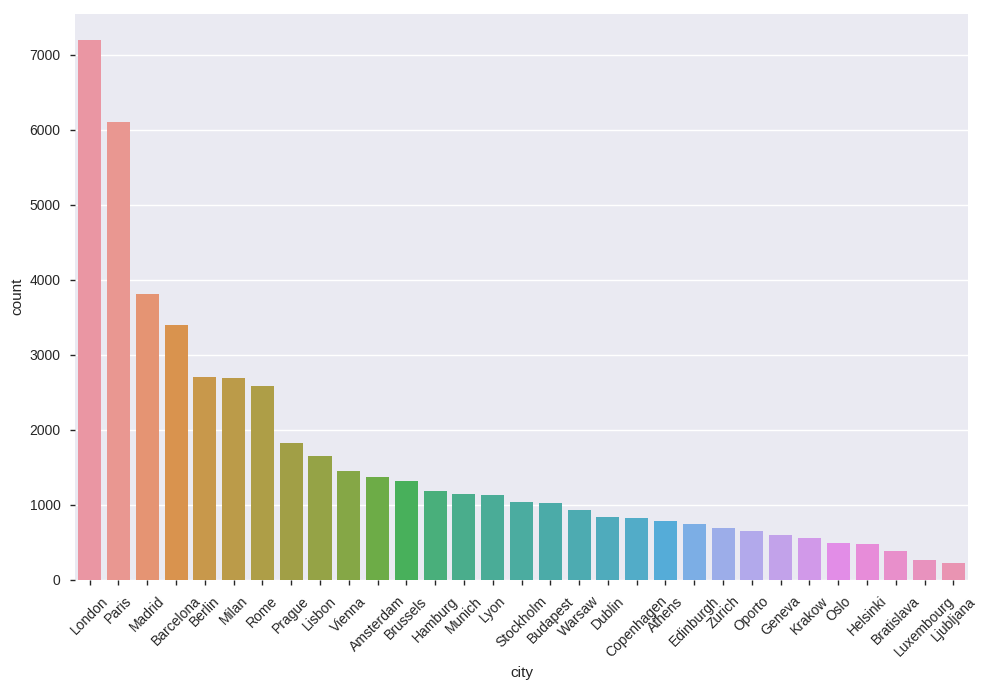

In [64]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(data['city'], order=data['city'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

### London, Paris имеет наибольшее количество отзывов, в тоже время Ljubljana, Luxenbourg have the least number of reviews

### Посмотрим распределение признака

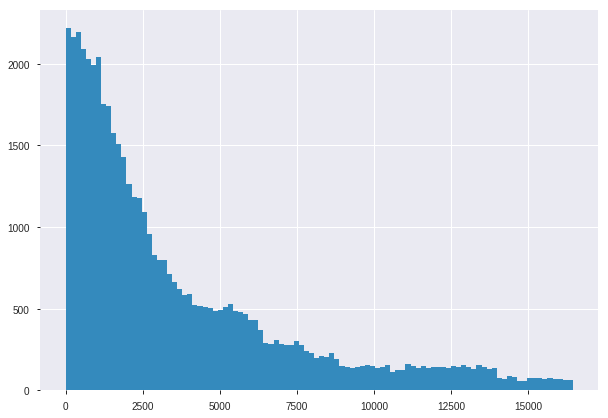

In [65]:
plt.rcParams['figure.figsize'] = (10,7)
data['rank'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

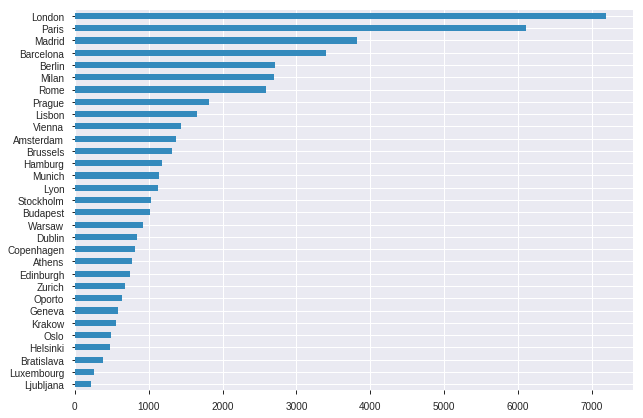

In [66]:
data['city'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

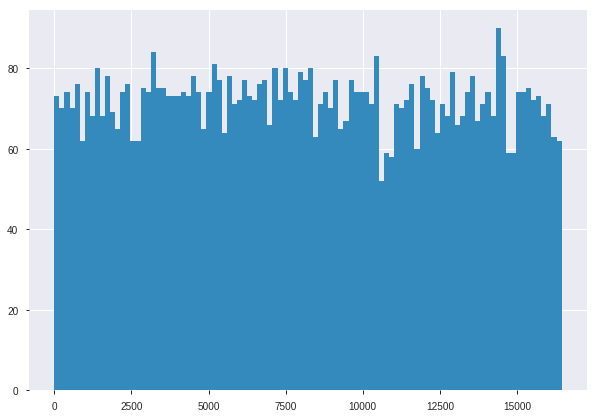

In [67]:
data['rank'][data['city'] =='London'].hist(bins=100)

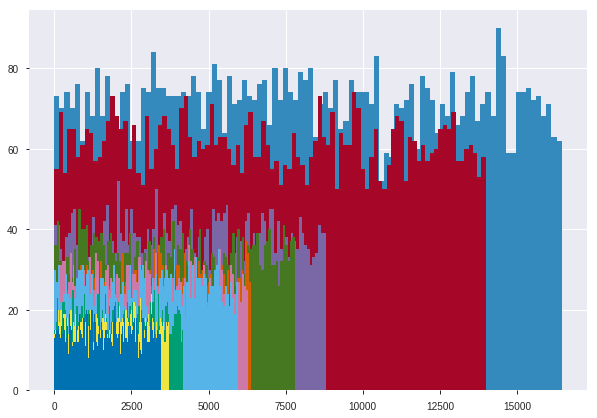

In [68]:
# посмотрим на топ 10 городов
for x in (data['city'].value_counts())[0:10].index:
    data['rank'][data['city'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [69]:
mean_Ranking_on_City = data.groupby(['city'])['rank'].mean()
count_Restorant_in_City = data['city'].value_counts(ascending=False)
data['mean_Ranking_on_City'] = data['city'].apply(lambda x: mean_Ranking_on_City[x])
data['count_Restorant_in_City'] = data['city'].apply(lambda x: count_Restorant_in_City[x])
data['norm_rank_on_Rest_in_City'] = (data['rank'] - data['mean_Ranking_on_City']) / data['count_Restorant_in_City']

### Посмотрим распределение целевой переменной

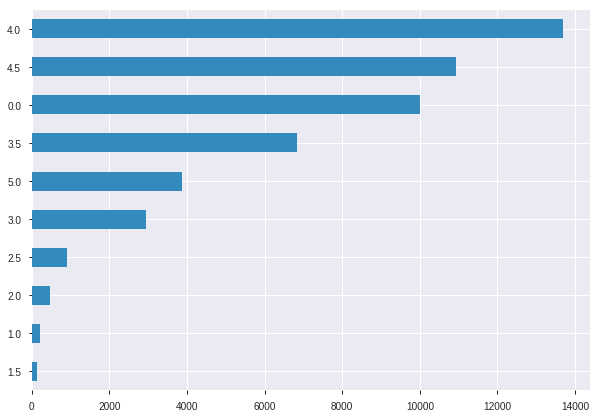

In [70]:
data['rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

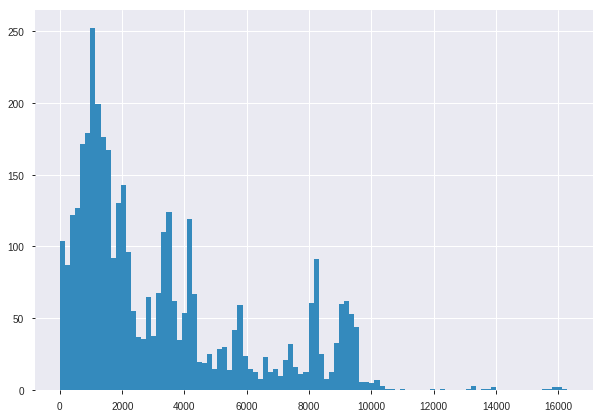

In [71]:
data['rank'][data['rating'] == 5].hist(bins=100)

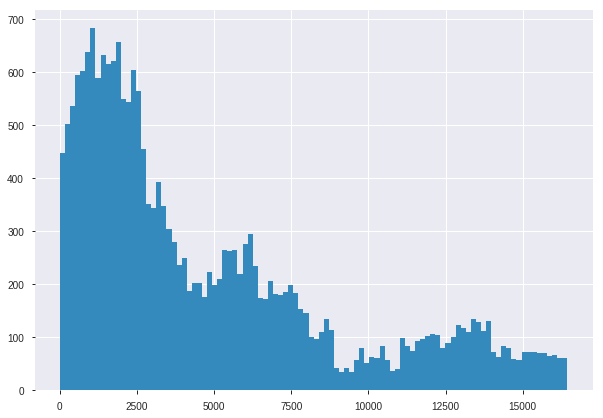

In [72]:
data['rank'][data['rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

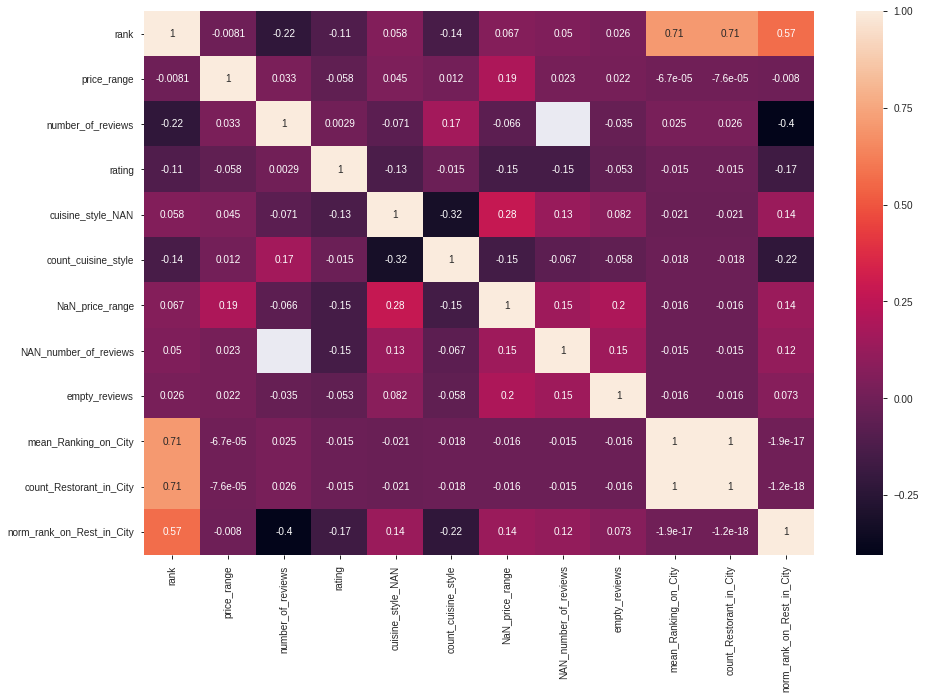

In [73]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),annot=True, fmt='.2g')


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [74]:
# на всякий случай, заново подгружаем данные
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
#
#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#data.info()

## Feature Engineering - генерация новых признаков

In [75]:
# вытащим дату из ревью и создадим новые критерии
data['date_of_Review'] = data['reviews'].str.findall('\d+/\d+/\d+')
data['len_date'] = data['date_of_Review'].apply(lambda x: len(x))

In [76]:
# есть значение 3 надо разобраться что там
print("кол-во значений Reviews с тремя датами :=" , len(data[data['len_date']==3]))
print("значения Reviews с тремя датами :=")
temp_list = data[data['len_date']==3].reviews.to_list()
display(data[data['len_date']==3].reviews.to_list())
print("даты после обработки регулярными выражениями:")
display([re.findall('\d+/\d+/\d+', x) for x in temp_list])

кол-во значений Reviews с тремя датами := 4
значения Reviews с тремя датами :=


["[['We visited 21/10/17', 'Best Kebab in London'], ['12/22/2017', '10/19/2017']]",
 "[['Good Museum Cafeteria', 'Lunch 30/5/2017'], ['04/13/2017', '05/30/2017']]",
 "[['The desserts arcade !', 'Visit today 3/1/2017'], ['06/02/2017', '01/03/2017']]",
 "[['lunch 29/9/2016', 'Unplanned Great Dinner'], ['09/30/2016', '08/25/2016']]"]

даты после обработки регулярными выражениями:


[['21/10/17', '12/22/2017', '10/19/2017'],
 ['30/5/2017', '04/13/2017', '05/30/2017'],
 ['3/1/2017', '06/02/2017', '01/03/2017'],
 ['29/9/2016', '09/30/2016', '08/25/2016']]

In [77]:
# видим что люди указывали даты в отзывах и эти даты попали в обработку
# из-за этого возникнут ошибки так как даты не верные и их формат отличается и формата выгрузки
# при этом таких строк всего четыре (4), можно было бы их не исправлять а выбросить потому что 17 
# год явно приведет к выбросу с которым надо будет разбираться. Выбрасывать жалко, тогда исправим,
# тем более, что это достачно просто

data['len_date'].date_of_Review = data[data['len_date']==3].date_of_Review.apply(lambda x: x.pop(0))

In [78]:
# также есть значение 1 надо разобраться что там
print("кол-во значений Reviews с одной датой :=" , len(data[data['len_date']==1]))
display(data[data['len_date']==1].reviews[:4])

кол-во значений Reviews с одной датой := 5681


12    [['You always feel very Welcome at this cozy.....
31                 [['Very good food'], ['09/24/2017']]
48                         [['Thomas'], ['01/06/2016']]
50    [['The best in Budapest so far'], ['03/05/2017']]
Name: reviews, dtype: object

In [79]:
# оказалось, что есть отзывы с одним (1) отзывом и их достаточно много 5680 из (40000-6471) это 17%
# сохраним это на всякий случай, чтобы не потерять
data['one_Review'] = (data['len_date']==1).astype('float64')

# заполним перерыв между отзывами (по отзывам где len = 2) и насколько давно был сделан последний самый свежий отзыв
# создадим для этого функции:
def time_to_now(row):
    if row['date_of_Review'] == []:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['date_of_Review']).max()

def time_between_Reviews(row):
    if row['date_of_Review'] == []:
        return None
    return pd.to_datetime(row['date_of_Review']).max() - pd.to_datetime(row['date_of_Review']).min()

data['day_to_now'] = data.apply(time_to_now, axis = 1).dt.days
data['day_between_Reviews'] = data[data['len_date']==2].apply(time_between_Reviews, axis = 1).dt.days

Созданы новые признаки:

* empty_Reviews - незаполненные отзывы
* date_of_Review - даты из отзывов
* len_date - кол-во дат в отзыве
* day_to_now - насколько давно был сделан последний самый свежий отзыв в днях
* day_between_Reviews - перерыв между отзывами в днях

In [80]:
df_city_dummies = pd.get_dummies(data['city'], dummy_na=False).astype('float64')
data = pd.concat([data,df_city_dummies], axis=1)

In [81]:
population_city_dict = {}
country_city_dict = {}
# Получаем словари популяции по городам, а так же ISO код страны по городу
population_city_dict, country_city_dict = get_city_population_and_country(data)

In [82]:
# сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
data['unique_cuisine_style'] = data['cuisine_style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')

In [83]:
# Вычисляем страну для города в каждой строке
data['country'] = data["city"].apply(lambda x: country_city_dict[x])

In [84]:
# Вычисляем к-во ресторанов для города в каждой строке
restorants_in_city = data.groupby('city')['rank'].count().to_dict()
data['restaurants_count'] = data['city'].map(restorants_in_city)

In [85]:
# Вычисляем население (в тыс. чел) для города в каждой строке
data['population'] = data["city"].map(population_city_dict)

In [86]:
# Вычисляем к-во ресторанов на 1000 чел для города в каждой строке
data['restaurants_for_population'] = data['restaurants_count'] / (data['population']*1000)

In [87]:
# Вычисляем является ли город столицей в каждой строке
capital_city_dict = get_capital_city_dict(data)
data['is_capital'] = data["city"].map(capital_city_dict)

### Получаем относительную позицию ресторана среди всех ресторанов города

In [88]:
data['weighed_rank'] = data.apply(lambda x: get_weighed_rank_rk(x), axis=1)

In [89]:
CityMinMax = data.groupby('city')['rank'].agg([min,max])
CityMinMax = CityMinMax.reset_index()
data['weighed_rank_min_max'] = data.apply(lambda x: get_weighed_rank(x), axis=1)

In [90]:
# Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня; isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
data['is_most_pop_cuisine'] = data['cuisine_style'].apply(lambda x: 1 if most_popular_cuisine in x else 0 )
data['is_multy_cuisine'] = data['count_cuisine_style'].apply(lambda x: 1 if  x >= average_cuisines_count else 0 )

In [91]:
data['reviews_txt_NaN'] = data['reviews'].apply(lambda x: x ==  '[[], []]')

data['reviews'] = data['reviews'].fillna('[[], []]')
data['reviews'] = data['reviews'].apply(lambda x: cleanup_string(x))

In [92]:
#len(data[pd.isna(data.number_of_reviews)])
#len(df_main[pd.isna(df_main.number_of_reviews)])
#data = data.dropna(subset=['number_of_reviews'],axis=0)
#len(data[pd.isna(data.number_of_reviews)])

In [93]:
# RevTimeDelta - время между review в днях
data['dev_time_delta'] = data['reviews'].apply(rev_time_delta)

In [94]:
# Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other
top_cityes = data['city'].value_counts()[0:10].index.to_list()
data['top_cityes'] = data.city.apply(lambda x: x if x in top_cityes else 'Other_City')

In [95]:
# К-во позитивных слов в представленных отзывах
data['positive_words'] = data['reviews'].apply(lambda x: count_positive_words_proportion(x))

In [96]:
# Список уникальных позитивных слов в представленных отзывах
data['positive_words_list'] = data['reviews'].apply(lambda x: list_positive_words(x))

In [97]:
cuisines_in_city={}
cuisines_count_in_city={}
for city_name, group in data.groupby('city'):

    cuisines = group['cuisine_style'].apply(get_cuisines)
   
    cuisines_list = list(itertools.chain.from_iterable(cuisines))
    #cusines_list = [x for x in cusines_list if x != 'Vegetarian Friendly'] # удаляем 'Vegetarian Friendly' - она "забивает" все результаты
    cuisines_in_city[city_name] = Counter(cuisines_list)

for city_name in cuisines_in_city.keys():
    cuisines_count_in_city[city_name] = len(cuisines_in_city[city_name])

data['cuisines_count_in_city'] = data['city'].map(cuisines_count_in_city)

In [98]:
data['weighed_cuisines_count'] = data['count_cuisine_style'] / data['cuisines_count_in_city']

In [99]:
data['most_common_cuisine_in_city'] = data['city'].apply(lambda x: cuisines_in_city[x].most_common(1)[0][0])

In [100]:
data['cuisine_style'] = data.apply(lambda x: x['cuisine_style'] if x['cuisine_style_NAN'] == False else [x['most_common_cuisine_in_city']], axis=1)

In [101]:
# Как часто в городе оставляют отзывы
data['NRP'] = data['number_of_reviews'] / data['population']

In [102]:
# Ранг ресторана с учетом частоты отзывов в городе
data['WRR'] =  data['weighed_rank']  *  data['NRP'] 

In [103]:
data['relative_price_range'] = data['price_range'] / data['weighed_rank']

In [104]:
# Средняя цена в городе
price_in_city_dict = data.groupby('city')['price_range'].mean().to_dict()
data['price_in_city'] = data['city'].map(price_in_city_dict)

In [105]:
# Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
import warnings; warnings.simplefilter('ignore')
data['restaurant_net_id'] = data['rest_id'].apply(lambda x: x.split('_')[1])
NetworkRestorants = data[data['restaurant_net_id'].isin(data['restaurant_net_id'].value_counts()[data['restaurant_net_id'].value_counts()>2].index)]
NetworkRestorants['is_network_restaurant'] = True
data['is_network_restaurant'] = NetworkRestorants['is_network_restaurant']
data['is_network_restaurant'] = data['is_network_restaurant'].fillna(False)

In [106]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other - это почти всегда дает улучшение предсказания
N=30 

s = data['cuisine_style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
print(slist)

сuisine_top_N = set(pd.Series(slist).value_counts()[:N].index)  
data['сuisine_top_N']=data['cuisine_style'].apply(lambda x: is_cuisine_top_N(x))

['Bar', 'Pub', 'European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options', 'Vegetarian Friendly', 'Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options', 'Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options', 'French', 'Cafe', 'Fast Food', 'European', 'Portuguese', 'European', 'European', 'Scandinavian', 'Italian', 'Italian', 'Italian', 'Greek', 'Vegetarian Friendly', 'European', 'Czech', 'Eastern European', 'Central European', 'French', 'Pizza', 'Vegetarian Friendly', 'Vegan Options', 'Bar', 'British', 'Pub', 'Vegetarian Friendly', 'Gluten Free Options', 'European', 'Italian', 'Pizza', 'European', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegetarian Friendly', 'Bar', 'Pizza', 'British', 'Vegetarian Friendly', 'Vegan Options', 'Mediterranean', 'Spanish', 'Vegetarian Friendly', 'Italian', 'Mediterranean', 'Pizza', 'Spanish', 'Vegetarian Friendly', 'Vegetarian Friendly', 'Italian',

In [107]:
сuisine_top_N = set(pd.Series(slist).value_counts()[:N].index)  
data['сuisine_top_N']=data['cuisine_style'].apply(lambda x: is_cuisine_top_N(x))

In [108]:
final_columns = []

In [109]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    global final_columns
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['ID_TA','URL_TA'], axis = 1, inplace=True)
    if 'name' in df_output.columns:
        df_output.drop(['name'], axis = 1, inplace=True)
        df_output.columns = ['city', 'cuisine_style', 'rank', 'rating', 'price_range','number_of_reviews', 'reviews']
    else:
    # переименовываем колонки
        df_output.columns = ['rest_id','city','cuisine_style','rank','price_range','number_of_reviews','reviews','sample','rating']
    
    
    print("2. NAN")
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output = df_output.dropna(subset=['number_of_reviews'],axis=0)
    
    df_output['cuisine_style_NAN'] = df_output['cuisine_style'].isna()
    df_output['cuisine_style'] = df_output['cuisine_style'].fillna("['Other']")
    df_output['cuisine_style'] = df_output['cuisine_style'].str.findall(r"'(\b.*?\b)'") 
    temp_list = df_output['cuisine_style'].tolist()
    temp_counter=Counter(list_unrar(temp_list))
    
    # заполним значения в переменной по словарю
    dict_value_price = {'$':1,'$$ - $$$':2,'$$$$':3}
    df_output['price_range']=df_output['price_range'].apply(lambda x: dict_value_price.get(x,x))
    
    most_common_price_range=df_output['price_range'].value_counts().index[0]
    # поэтому заполняем пропуски наиболее популярным ответом
    df_output['price_range'] = df_output['price_range'].fillna(most_common_price_range)
    
    df_output['reviews_txt_NaN'] = df_output['reviews'].apply(lambda x: x ==  '[[], []]')
    # Поработаем с отзывами и датами
    df_output['reviews'] = df_output['reviews'].fillna('[[], []]')
    
    df_output['reviews'] = df_output['reviews'].apply(lambda x: cleanup_string(x))
    
    
    
    print("3. Encoding")
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na

    df_city_dummies = pd.get_dummies(df_output['city'], dummy_na=False).astype('float64')
    df_output = pd.concat([df_output,df_city_dummies], axis=1)
    
    
    
    print("4. Feature Engineering ")
    # ################### 4. Feature Engineering ####################################################
    population_city_dict = {}
    country_city_dict = {}
    # Получаем словари популяции по городам, а так же ISO код страны по городу
    population_city_dict, country_city_dict = get_city_population_and_country(df_output)
    # Вычисляем население (в тыс. чел) для города в каждой строке
    df_output['population'] = df_output["city"].map(population_city_dict)
    
    # сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
    list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
    df_output['unique_cuisine_style'] = df_output['cuisine_style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')
    
    # Вычисляем страну для города в каждой строке
    df_output['country'] = df_output["city"].apply(lambda x: country_city_dict[x])
    
    
    # Вычисляем кол-во ресторанов для города в каждой строке
    restorants_in_city = df_output.groupby('city')['rank'].count().to_dict()
    df_output['restaurants_count'] = df_output['city'].map(restorants_in_city)
    
    # Вычисляем является ли город столицей в каждой строке
    capital_city_dict = get_capital_city_dict(df_output)
    df_output['is_capital'] = df_output["city"].map(capital_city_dict)
    
    df_output['weighed_rank'] = df_output.apply(lambda x: get_weighed_rank_rk(x), axis=1)
    CityMinMax = df_output.groupby('city')['rank'].agg([min,max])
    CityMinMax = CityMinMax.reset_index()
    df_output['weighed_rank_min_max'] = df_output.apply(lambda x: get_weighed_rank(x), axis=1)
    
    mean_Ranking_on_City = df_output.groupby(['city'])['rank'].mean()
    count_Restarant_in_City = df_output['city'].value_counts(ascending=False)
    df_output['mean_Ranking_on_City'] = df_output['city'].apply(lambda x: mean_Ranking_on_City[x])
    df_output['count_Restarant_in_City'] = df_output['city'].apply(lambda x: count_Restarant_in_City[x])
    df_output['norm_rank_on_Rest_in_City'] = (df_output['rank'] - df_output['mean_Ranking_on_City']) / df_output['count_Restarant_in_City']
    
    
    
    # вытащим дату из ревью и создадим новые критерии
    df_output['date_of_Review'] = df_output['reviews'].str.findall('\d+/\d+/\d+')
    df_output['len_date'] = df_output['date_of_Review'].apply(lambda x: len(x))

    df_output['one_Review'] = (df_output['len_date']==1).astype('float64')

    # dev_time_delta - время между review в днях
    df_output['dev_time_delta'] = df_output['reviews'].apply(rev_time_delta)
    
    df_output['len_date'].date_of_Review = df_output[df_output['len_date']==3].date_of_Review.apply(lambda x: x.pop(0))
    df_output['day_to_now'] = df_output.apply(time_to_now, axis = 1).dt.days
    df_output['day_between_Reviews'] = df_output[df_output['len_date']==2].apply(time_between_Reviews, axis = 1).dt.days
    
    # Флаги (1/0) is_most_pop_cuisine - есть ли в ресторане самая популярная кухня; 
    # is_multy_cuisine - к-во кухонь в ресторане больше или столько же чем в среднем
    df_output['is_most_pop_cuisine'] = df_output['cuisine_style'].apply(lambda x: 1 if most_popular_cuisine in x else 0 )
    df_output['count_cuisine_style'] = df_output['cuisine_style'].apply(lambda x: len(x)).astype('float64')
    df_output['is_multy_cuisine'] = df_output['count_cuisine_style'].apply(lambda x: 1 if  x >= average_cuisines_count else 0 )
    
    
    # К-во позитивных слов в представленных отзывах
    df_output['positive_words'] = df_output['reviews'].apply(lambda x: count_positive_words_proportion(x))
    
    # Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other
    top_cityes = df_output['city'].value_counts()[0:10].index.to_list()
    df_output['top_cityes'] = df_output.city.apply(lambda x: x if x in top_cityes else 'Other_City')
    
    # Список уникальных позитивных слов в представленных отзывах
    df_output['positive_words_list'] = df_output['reviews'].apply(lambda x: list_positive_words(x))
    
    # получение стилей кухни в городе
    cuisines_in_city={}
    cuisines_count_in_city={}
    for city_name, group in df_output.groupby('city'):

        cuisines = group['cuisine_style'].apply(get_cuisines)

        cuisines_list = list(itertools.chain.from_iterable(cuisines))
        #cusines_list = [x for x in cusines_list if x != 'Vegetarian Friendly'] # удаляем 'Vegetarian Friendly' - она "забивает" все результаты
        cuisines_in_city[city_name] = Counter(cuisines_list)

    for city_name in cuisines_in_city.keys():
        cuisines_count_in_city[city_name] = len(cuisines_in_city[city_name])
    df_output['cuisines_count_in_city'] = df_output['city'].map(cuisines_count_in_city)

    
    df_output['weighed_cuisines_count'] = df_output['count_cuisine_style'] / df_output['cuisines_count_in_city']
    
    df_output['most_common_cuisine_in_city'] = df_output['city'].apply(lambda x: cuisines_in_city[x].most_common(1)[0][0])
    #
    df_output['cuisine_style'] = df_output.apply(lambda x: x['cuisine_style'] if x['cuisine_style_NAN'] == False else [x['most_common_cuisine_in_city']], axis=1)
    
    # Как часто в городе оставляют отзывы
    df_output['NRP'] = df_output['number_of_reviews'] / df_output['population']
    
    # Ранг ресторана с учетом частоты отзывов в городе
    df_output['WRR'] =  df_output['weighed_rank']  *  df_output['NRP']
    
    df_output['relative_price_range'] = df_output['price_range'] / df_output['weighed_rank']
    
    # Средняя цена в городе
    price_in_city_dict = df_output.groupby('city')['price_range'].mean().to_dict()
    df_output['price_in_city'] = df_output['city'].map(price_in_city_dict)
    
    if 'rest_id' in df_output.columns:
        # Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
        import warnings; warnings.simplefilter('ignore')
        df_output['restaurant_net_id'] = df_output['rest_id'].apply(lambda x: x.split('_')[1])
        NetworkRestorants = df_output[df_output['restaurant_net_id'].isin(df_output['restaurant_net_id'].value_counts()[df_output['restaurant_net_id'].value_counts()>2].index)]
        NetworkRestorants['is_network_restaurant'] = True
        df_output['is_network_restaurant'] = NetworkRestorants['is_network_restaurant']
        df_output['is_network_restaurant'] = df_output['is_network_restaurant'].fillna(False)
    
    # Сокращаем список кухонь для анализа до N - основных, остальные Other - это почти всегда дает улучшение предсказания
    N=30 

    s = df_output['cuisine_style'].apply(lambda x: get_cuisines(x))
    slist =[]
    for x in s:
        slist.extend(x)

    сuisine_top_N = set(pd.Series(slist).value_counts()[:N].index)  
    df_output['сuisine_top_N']=df_output['cuisine_style'].apply(lambda x: is_cuisine_top_N(x))
    
    print("5. Clean")
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    # Собираем Dummies: city, price_range, country_range, Cuisine top N

    dff = pd.get_dummies(df_output['сuisine_top_N'].apply(pd.Series).stack()).sum(level=0)
    df_output = pd.concat([df_output,dff], axis=1)    
    
    df_mcc = pd.get_dummies(df_output['most_common_cuisine_in_city'], prefix = 'MCC')
    df_output = pd.concat([df_output,df_mcc], axis=1)
    
    df_city = pd.get_dummies(df_output['city'], prefix = 'city_range')
    df_output = pd.concat([df_output,df_city], axis=1)
    
    df_price_range = pd.get_dummies(df_output['price_range'], prefix = 'price_range') 
    df_output = pd.concat([df_output,df_price_range], axis=1)
    
    df_country_range = pd.get_dummies(df_output['country'], prefix = 'country_range',) 
    df_output = pd.concat([df_output,df_country_range], axis=1)
    
    df_output['positive_words_list'] = df_output['positive_words_list'].fillna('NAN')
    df_positive_words_range = pd.get_dummies(df_output['positive_words_list'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)
    df_output = pd.concat([df_output,df_positive_words_range], axis=1)
    
    final_columns.extend(dff.columns.tolist())
    final_columns.extend(df_mcc.columns.tolist())
    final_columns.extend(df_city.columns.tolist())
    final_columns.extend(df_price_range.columns.tolist())
    final_columns.extend(df_country_range.columns.tolist())
    final_columns.extend(df_positive_words_range.columns.tolist())
    
    return df_output

In [110]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [111]:
len(df_test)

10000

#### Запускаем и проверяем что получилось

In [112]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

2. NAN
3. Encoding
4. Feature Engineering 
5. Clean


,rest_id,city,cuisine_style,rank,price_range,number_of_reviews,reviews,sample,rating,cuisine_style_NAN,...,wonderfully,work,worked,works,world-famous,worth,worthwhile,worthy,wow,yay
45693,id_496,London,"[French, European, Wine Bar, Vegetarian Friend...",497.0,3.0,261.0,[['Outstanding food with some extraordinary w....,1,4.5,False,...,0,0,0,0,0,0,0,0,0,0
47330,id_1435,Rome,"[Wine Bar, Italian, Bar, Mediterranean, Cafe, ...",1436.0,2.0,125.0,"[['Nice place', 'Good spot for a few drinks be...",1,4.5,False,...,0,0,0,0,0,0,0,0,0,0
15724,id_999,Warsaw,[European],1000.0,2.0,5.0,"[[], []]",1,4.5,True,...,0,0,0,0,0,0,0,0,0,0
44042,id_12060,London,[Seafood],12070.0,2.0,5.0,"[['Refurbished', 'M D s '], ['08/10/2016', '08...",1,4.0,False,...,0,0,0,0,0,0,0,0,0,0
13386,id_1248,Amsterdam,"[Mexican, Fast Food, Fusion, Vegetarian Friend...",1251.0,1.0,58.0,"[['Great burrito for takeaway', 'friendly peop...",1,4.0,False,...,0,0,0,0,0,0,0,0,0,0
25696,id_252,Oslo,"[Scandinavian, Norwegian]",253.0,2.0,154.0,"[['A nice restaurant for the laid-backs', 'Tra...",1,3.5,False,...,0,0,0,0,0,0,0,0,0,0
25651,id_2086,Lyon,[French],2087.0,2.0,21.0,"[[], []]",1,3.5,True,...,0,0,0,0,0,0,0,0,0,0
10110,id_4278,Milan,[Chinese],4281.0,1.0,83.0,"[['Value for money near the centrale', 'The be...",1,3.5,False,...,0,0,0,0,0,0,0,0,0,0
35398,id_1571,Berlin,[Italian],1573.0,2.0,35.0,"[['Reward for an afternoon shopping', 'Delicio...",1,4.5,False,...,0,0,0,0,0,0,0,0,0,0
23380,id_4381,Barcelona,[Mediterranean],4382.0,2.0,29.0,"[[], []]",1,4.0,False,...,0,0,0,0,0,0,0,0,0,0


In [113]:
df_main = TA_compet
df_main.columns

Index(['name', 'city', 'cuisine_style', 'rank', 'rating', 'price_range',
       'number_of_reviews', 'reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [114]:
df_preproc_big = preproc_data(df_main)
df_preproc_big.sample(10)

2. NAN
3. Encoding
4. Feature Engineering 
5. Clean


,city,cuisine_style,rank,rating,price_range,number_of_reviews,reviews,cuisine_style_NAN,reviews_txt_NaN,Amsterdam,...,worked,works,world-famous,worth,worthwhile,worthy,wow,wowed,yay,youthful
98235,Paris,[French],8840.0,4.5,2.0,20.0,"[[], []]",True,True,0.0,...,0,0,0,0,0,0,0,0,0,0
115895,Stockholm,"[French, Cafe, International, European]",817.0,4.0,1.0,13.0,"[['Good Coffee and Snacks', 'I found My coffee...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
102250,Paris,"[French, European]",12855.0,3.0,2.0,63.0,"[['Friendly service, food okay', 'Nothing to w...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
41794,Lisbon,"[Mediterranean, European, Portuguese, Soups, I...",702.0,4.5,2.0,76.0,"[['Very good food and excellent service', 'Sup...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
42271,Lisbon,"[Mediterranean, European, Portuguese, Vegetari...",1179.0,4.0,2.0,57.0,"[['Friendly waitress and good food', 'A real t...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
84321,Munich,"[German, European, Central European, Vegetaria...",720.0,4.0,2.0,60.0,"[['Great Party', 'Nice food nice service'], ['...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
57768,London,"[Cafe, Healthy, Vegetarian Friendly, Vegan Opt...",12198.0,3.5,2.0,47.0,"[['Good food; interesting service', 'Lovely co...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
104795,Prague,"[Indian, Asian, Bangladeshi, Vegetarian Friend...",525.0,4.5,2.0,112.0,"[['delicious food, lovely staff', 'Delicious F...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
55741,London,"[Japanese, Sushi, Asian]",10170.0,4.0,2.0,64.0,"[['Best Japanese in London', 'Arrogant and dis...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0
120563,Vienna,"[Austrian, European]",2781.0,4.0,2.0,5.0,"[['Hotel now a carpenters shop', 'typical dish...",False,False,0.0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
for col in df_preproc_big.columns:
    if True in pd.isna(df_preproc_big[col]).value_counts(dropna=False):
        print(col,":",pd.isna(df_preproc_big[col]).value_counts(dropna=False)[1])

rank : 9651
rating : 9630
number_of_reviews : 17344
weighed_rank : 9651
weighed_rank_min_max : 9651
norm_rank_on_Rest_in_City : 9651
day_to_now : 28710
day_between_Reviews : 42055
NRP : 17344
WRR : 17372
relative_price_range : 9651


In [116]:
pd.isna(df_preproc_big['WRR']).value_counts(dropna=False)[1]

17372

In [117]:
df_preproc_big_test = df_preproc_big.copy()
df_preproc_big_test = df_preproc_big_test.fillna({'rating':0,'rank':0,'reviews':0},inplace=True)

In [118]:
def fit_predict(data, columns):

    data = data[columns]
    y = data.rating.values            # наш таргет
    X = data.drop(['rating'], axis=1)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

    MAE = []

    for train, test in kfold.split(X, y):
        model.fit(X[train],y[train],validation_data= (X[test],y[test]),epochs=50,verbose=0)
        #model.evaluate(X[test],y[test], verbose=0)
        y_pred = model.predict(predictors_test)
        MAE.append(metrics.mean_absolute_error(y[test], y_pred))
        print(f"Test set MAE for {i+1} cycle:{MAE[i]}")
        
    print(f'Mean MAE for {len(MAE)}-fold cross validation : {np.mean(MAE)}') 

    # Обучаем модель на тестовом наборе данных
    #model.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    #y_pred = model.predict(X_test)
    #print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')

In [119]:
main_columns = list()

main_columns = final_columns
columns = ['rating',
           'price_range',
           'number_of_reviews',
           'cuisine_style_NAN',
           'reviews_txt_NaN',
           'population',
           'restaurants_count',
           'is_capital', 
           'weighed_rank', 
           'weighed_rank_min_max', 
           'norm_rank_on_Rest_in_City',
           'dev_time_delta', 
           'is_most_pop_cuisine', 
           'count_cuisine_style', 
           'is_multy_cuisine',
           'positive_words', 
           'cuisines_count_in_city', 
           'weighed_cuisines_count', 
           'NRP', 
           'WRR', 
           'relative_price_range',
           'price_in_city',
           'rank'
          ]
main_columns.extend(columns)

main_columns = [col for col in main_columns if col not in ['sample', 'is_network_restaurant']]
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
fit_predict(df_preproc_big_test, list(set(columns)))

TypeError: 'NoneType' object is not subscriptable

### Получить список колонок в которых есть пропуски и заполним их

In [120]:
df_preproc.info()
df_preproc.columns
final_columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 842 entries, rest_id to yay
dtypes: bool(3), float64(51), int64(10), object(10), uint8(768)
memory usage: 63.8+ MB


['American',
 'Asian',
 'Bar',
 'British',
 'Cafe',
 'Central European',
 'Chinese',
 'European',
 'Fast Food',
 'French',
 'German',
 'Gluten Free Options',
 'Halal',
 'Indian',
 'International',
 'Italian',
 'Japanese',
 'Mediterranean',
 'Middle Eastern',
 'Other',
 'Pizza',
 'Portuguese',
 'Pub',
 'Seafood',
 'Spanish',
 'Sushi',
 'Thai',
 'Vegan Options',
 'Vegetarian Friendly',
 'Wine Bar',
 'MCC_European',
 'MCC_French',
 'MCC_Greek',
 'MCC_Italian',
 'MCC_Other',
 'MCC_Portuguese',
 'MCC_Spanish',
 'MCC_Vegetarian Friendly',
 'city_range_Amsterdam',
 'city_range_Athens',
 'city_range_Barcelona',
 'city_range_Berlin',
 'city_range_Bratislava',
 'city_range_Brussels',
 'city_range_Budapest',
 'city_range_Copenhagen',
 'city_range_Dublin',
 'city_range_Edinburgh',
 'city_range_Geneva',
 'city_range_Hamburg',
 'city_range_Helsinki',
 'city_range_Krakow',
 'city_range_Lisbon',
 'city_range_Ljubljana',
 'city_range_London',
 'city_range_Luxembourg',
 'city_range_Lyon',
 'city_range_M

In [121]:
# проверяем заполнение
#display(df_preproc.describe().columns)
#columns = df_preproc.describe().columns

#df_preproc = df_preproc[columns]

In [122]:
main_columns = []
main_columns = final_columns
columns = ['sample',
           'rating',
           'price_range',
           'number_of_reviews',
           'cuisine_style_NAN',
           'reviews_txt_NaN',
           'population',
           'restaurants_count',
           'is_capital', 
           'weighed_rank', 
           'weighed_rank_min_max',
           'norm_rank_on_Rest_in_City',
           'dev_time_delta', 
           'is_most_pop_cuisine', 
           'count_cuisine_style', 
           'is_multy_cuisine',
           'positive_words', 
           'cuisines_count_in_city', 
           'weighed_cuisines_count', 
           'NRP', 
           'WRR', 
           'relative_price_range',
           'price_in_city',
           'rank',
           'is_network_restaurant'
          ]
main_columns.extend(columns)

In [123]:
df_preproc_test = df_preproc.copy()
df_preproc_test.fillna({'rating':0,'rank':0,'reviews':0,'number_of_reviews':0,'NRP':0,'WRR':0},inplace=True)
df_preproc_test = df_preproc_test[columns]
for col in df_preproc_test.columns:
    if True in pd.isna(df_preproc_test[col]).value_counts(dropna=False):
        print(col,":",pd.isna(df_preproc_test[col]).value_counts(dropna=False)[1])

In [124]:
train_data = df_preproc_test.query('sample == 1')
test_data = df_preproc_test.query('sample == 0')

In [125]:
train_data = train_data.drop(['sample'], axis=1)
test_data = test_data.drop(['sample'], axis=1)

In [126]:
# Теперь выделим тестовую часть
#train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
#test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [127]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [128]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 24), (40000, 24), (40000, 23), (32000, 23), (8000, 23))

In [129]:
# rating - the fuction aligns the final model resul to the Trip Advisor scale, which is multiple to 0.25 
def rating(prediction):
    if prediction < 0.25:
        return 0
    elif 0.25 < prediction <= 0.75:
        return 0.5
    elif 0.75 < prediction <= 1.25:
        return 1
    elif 1.25 <prediction <= 1.75:
        return 1.5
    elif 1.75 < prediction <= 2.25:
        return 2
    elif 2.25 < prediction <= 2.75:
        return 2.5
    elif 2.75 < prediction <= 3.25:
        return 3
    elif 3.25 < prediction <= 3.75:
        return 3.5
    elif 3.75 < prediction <= 4.25:
        return 4
    elif 4.25 < prediction <= 4.75:
        return 4.5
    else:
        return 5

# Model 
Сам ML

In [130]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [131]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [132]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [133]:
for i in range(y_pred.size):
    y_pred[i]=rating(y_pred[i])

In [134]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1736875


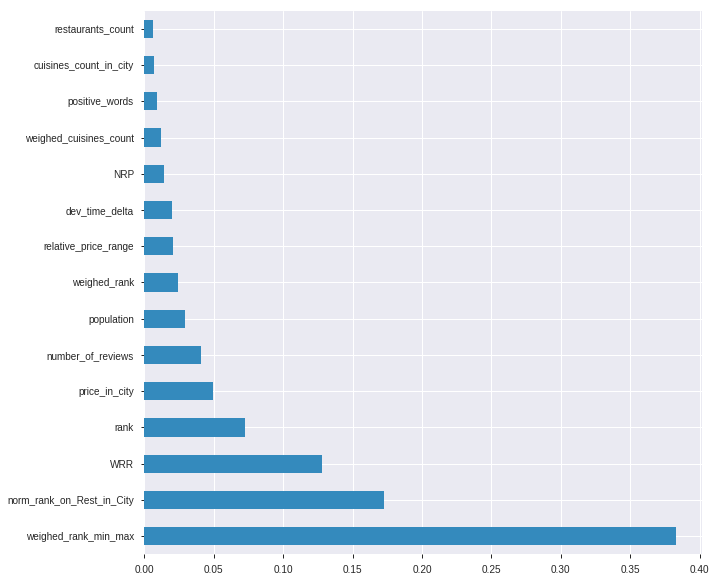

In [135]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [136]:
test_data.sample(10)

,rating,price_range,number_of_reviews,cuisine_style_NAN,reviews_txt_NaN,population,restaurants_count,is_capital,weighed_rank,weighed_rank_min_max,...,is_multy_cuisine,positive_words,cuisines_count_in_city,weighed_cuisines_count,NRP,WRR,relative_price_range,price_in_city,rank,is_network_restaurant
2298,0.0,2.0,15.0,False,False,0.825080,1372,1,2.048834,0.136,...,1,3.0,86,0.069767,18.180055,37.247912,0.976165,1.871720,2811.0,True
4674,0.0,1.0,61.0,False,False,8.173900,7193,1,0.633394,0.723,...,0,2.0,111,0.018018,7.462778,4.726876,1.578797,1.861949,4556.0,False
7221,0.0,2.0,89.0,False,False,1.744665,1021,1,0.525955,0.780,...,1,3.0,75,0.093333,51.012659,26.830360,3.802607,1.807052,537.0,False
3035,0.0,2.0,8.0,True,False,8.173900,7193,1,2.035312,0.110,...,0,1.0,111,0.009009,0.978725,1.992011,0.982650,1.861949,14640.0,True
5690,0.0,2.0,1272.0,False,False,8.173900,7193,1,0.120951,0.947,...,1,3.0,111,0.054054,155.617270,18.822053,16.535632,1.861949,870.0,False
8993,0.0,1.0,8.0,False,False,8.173900,7193,1,1.681218,0.265,...,1,1.0,111,0.027027,0.978725,1.645450,0.594807,1.861949,12093.0,False
4076,0.0,2.0,7.0,True,False,1.718187,1186,0,0.816189,0.647,...,0,2.0,76,0.013158,4.074062,3.325204,2.450413,1.940135,968.0,False
8475,0.0,2.0,8.0,False,True,1.272690,1816,1,1.392621,0.396,...,1,0.0,83,0.036145,6.285898,8.753875,1.436141,1.840308,2529.0,True
6310,0.0,2.0,256.0,False,False,0.547733,1647,1,0.075288,0.967,...,1,2.0,74,0.067568,467.381005,35.188370,26.564516,1.822101,124.0,True
5047,0.0,2.0,394.0,False,False,1.272690,1816,1,0.225220,0.903,...,1,1.0,83,0.060241,309.580495,69.723801,8.880196,1.840308,409.0,False


In [137]:
test_data = test_data.drop(['rating'], axis=1)

In [138]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [139]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [140]:
predict_submission

array([3.025, 4.32 , 4.46 , ..., 3.1  , 4.475, 4.31 ])

In [141]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [142]:
len(predict_submission)

10000

In [143]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.025
1,id_1,4.320
2,id_2,4.460
3,id_3,4.310
4,id_4,4.495
5,id_5,4.555
6,id_6,1.615
7,id_7,3.000
8,id_8,4.270
9,id_9,4.685


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
